# IS4226 Group 9 Strategy 2

## Strategy:
Mean reversion and momentum strategy. We would use indicators to identify undervalued stocks with Relative Strength Index (RSI) and Bollinger Bands (BB) and Volume Weighted Average Price (VWAP) and checking momentum with Exponential Moving Average (EMA).
### Buy
We would enter a buy position if the stock is undervalued and showing momentum to the upside.
### Sell
We would enter a short position if the stock is overvalued and showing momentum to the downside.

# Imports

In [12]:
#Imports
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from ta.volume import VolumeWeightedAveragePrice

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

# Backtesting Parameters

In [13]:
# Backtesting parameters 
start="2015-01-01"
end="2019-12-31"
stock_names = ["META", "AMZN", "AAPL", "NFLX", "GOOG"]
meta_stock = yf.download("META", start=start, end=end)
amzn_stock = yf.download("AMZN", start=start, end=end)
aapl_stock = yf.download("AAPL", start=start, end=end)
nflx_stock = yf.download("NFLX", start=start, end=end)
goog_stock = yf.download("GOOG", start=start, end=end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Functions for calculating indicators

In [14]:
#Functions
# For EMA Crossover
def EMA(data: pd.DataFrame, window: int):
    return data.ewm(span=window).mean()

# For RSI
def RSI(data: pd.DataFrame, window: int):
    return RSIIndicator(data["Close"], window=window).rsi()

# For Bollinger Band
def bollinger(data: pd.DataFrame, size: int, std_dev: int):
    data = data.copy()
    sma = data.rolling(window=size).mean()
    rstd = data.rolling(window=size).std()
    upper_band = sma + std_dev * rstd
    lower_band = sma - std_dev * rstd
    sma = sma.rename(columns={'Close': 'BB_sma'})
    upper_band = upper_band.rename(columns={'Close': 'BB_upper'})
    lower_band = lower_band.rename(columns={'Close': 'BB_lower'})
    return pd.concat([sma, lower_band, upper_band], axis=1).dropna()

# For Volume Weighted Average Price
def VWAP(data: pd.DataFrame, window: int):
    high = data["High"]
    low = data["Low"]
    close = data["Close"]
    volume = data["Volume"]
    return VolumeWeightedAveragePrice(high, low, close, volume, window=window).volume_weighted_average_price()

# For Average True Range
def ATR(data: pd.DataFrame):
    high = data["High"]
    low = data["Low"]
    close = data["Close"]
    return AverageTrueRange(high, low, close).average_true_range()

# Strategy 2:
* Only long or short positions
 * Long when RSI or BB or VWAP shows that a stock is oversold and supported by momentum using EMA
 * Short when RSI or BB or VWAP shows that a stock is overbought and supported by momentum using EMA

### Indicators used for trading signals

In [15]:
#Indicators

# For EMA Crossover
ema_fast_window = 5
ema_slow_window = 20

# For RSI
rsi_window = 14
rsi_buy_level = 30 #low level
rsi_sell_level = 70 #High level

# For Bollinger Band
bb_sma = 20
bb_std_dev = 2

# For Volume Weighted Average Price
vwap_window = 14

## Portfolio Returns using strategy 2

In [16]:
stocks = [meta_stock, amzn_stock, aapl_stock, nflx_stock, goog_stock]
portfolio = pd.DataFrame()

for i, stock in enumerate(stocks):
    # Get backtest data
    ema_fast = EMA(stock["Close"], ema_fast_window).rename("ema_fast")
    ema_slow = EMA(stock["Close"], ema_slow_window).rename("ema_slow")
    rsi = RSI(stock, rsi_window)
    bb = bollinger(stock[["Close"]], bb_sma, bb_std_dev)

    # atr = ATR(stock).rename("atr")
    vwap = VWAP(stock, vwap_window).rename("vwap")
    backtest_data = pd.DataFrame()
    backtest_data["Close"] = stock["Close"]
    backtest_data = pd.concat([backtest_data, ema_fast, ema_slow, rsi, bb, vwap], axis=1)
    backtest_data = backtest_data.dropna()
    position = []
    long = False
    status = 1 if long else -1

    # For each day
    for j in range(len(backtest_data)):
        day = backtest_data.iloc[j]
        ema_up = day["ema_fast"] > day["ema_slow"]
        ema_down = day["ema_fast"] < day["ema_slow"]
        rsi_buy = day["rsi"] < rsi_buy_level
        rsi_sell = day["rsi"] > rsi_sell_level
        bb_buy = day["Close"] < day["BB_lower"]
        bb_sell = day["Close"] > day["BB_upper"]
        vwap_check = day["vwap"] > day["Close"]
        if not long:
            if ema_up and (rsi_buy or bb_buy or vwap_check):
                status = 1
                long = True
        elif long:
            if ema_down and (rsi_sell or bb_sell):
                status = -1
                long = False
        position.append(status)
    backtest_data["Position"] = position

    #Computing returns
    backtest_data["Stock_Returns_Arithmetic"] = backtest_data["Close"] / backtest_data["Close"].shift(1) - 1
    backtest_data["Strategy_Returns"] = backtest_data["Stock_Returns_Arithmetic"] * backtest_data["Position"].shift(1)
    portfolio["stock"] = stock_names[i]
    portfolio["Strategy_Returns"] = backtest_data["Strategy_Returns"]
    portfolio["Log_Strategy_Returns"] = np.log(1 + portfolio["Strategy_Returns"])

portfolio["Gross_Cum_Portfolio_Returns"] = portfolio["Strategy_Returns"].cumsum().apply(np.exp)
portfolio["Cum_Max_Portfolio"] = portfolio["Gross_Cum_Portfolio_Returns"].cummax()

# Risk Return Statistics

In [17]:
# Check if each stock DataFrame has the 'Close' column before concatenating
maang_close_data = pd.concat([stock['Close'] for stock in stocks],axis=1)
maang_close_data.columns = stock_names  # Rename columns to match tickers
benchmark = maang_close_data.mean(axis=1)
benchmark_df = pd.DataFrame(benchmark, columns=['Benchmark'])
benchmark_df['Benchmark_Returns'] = benchmark_df['Benchmark'].pct_change()
benchmark_df["Log_Benchmark_Returns"] = np.log(1 + benchmark_df["Benchmark_Returns"].fillna(0))

portfolio = pd.concat([portfolio, benchmark_df], axis=1)

# Calculate Annual Benchmark Returns
daily1 = portfolio["Log_Benchmark_Returns"].mean()
annual1 = daily1 * 252
annual_regular1 = round(np.exp(annual1) - 1, 4) * 100
print(f"Annual Benchmark Returns: {annual_regular1}%")

# Annual Mean Returns
daily = portfolio["Log_Strategy_Returns"].mean()
annual = daily * 252
annual_regular = round(np.exp(annual) - 1, 4) * 100
print(f"Annual Mean Returns: {annual_regular}%")

# Annual Standard Deviation
daily_std = portfolio["Log_Strategy_Returns"].std()
annual_std = round(daily_std * (252 **0.5) * 100, 3)
print("Annual Standard Deviation: ", annual_std)

# Sharpe Ratio
sharpe = round(annual_regular / annual_std, 3)
print("Sharpe Ratio: ", sharpe)

# Beta
benchmark_var = portfolio["Benchmark_Returns"].var()
strategy_cov = portfolio["Strategy_Returns"].cov(portfolio["Benchmark_Returns"])
beta = round(strategy_cov / benchmark_var, 5)
print("Beta: ", beta)

# Alpha
alpha = annual - beta * (portfolio["Benchmark_Returns"].mean() * 252)
print("Alpha: ", round(alpha, 4))

# Drawdown
drawdown = portfolio["Cum_Max_Portfolio"] - portfolio["Gross_Cum_Portfolio_Returns"]
portfolio["Drawdown"] = drawdown
max_drawdown = round(portfolio["Drawdown"].max(), 4) * 100
print("Max Drawdown: ", max_drawdown)

# Finding Max Drawdown Period for Strategy
zero_periods_strategy = drawdown[drawdown == 0] # For all periods where orange and blue meet
delta_values_strategy = zero_periods_strategy.index[1:] - zero_periods_strategy.index[:-1] # Taking the difference from the previous period
max_days_strategy = delta_values_strategy.max().days
print('Max days of drawdown:', max_days_strategy)   

Annual Benchmark Returns: 31.05%
Annual Mean Returns: 20.79%
Annual Standard Deviation:  23.749
Sharpe Ratio:  0.875
Beta:  0.64169
Alpha:  -0.0068
Max Drawdown:  57.08
Max days of drawdown: 265


# Visualisation of Strategy Performance against benchmark


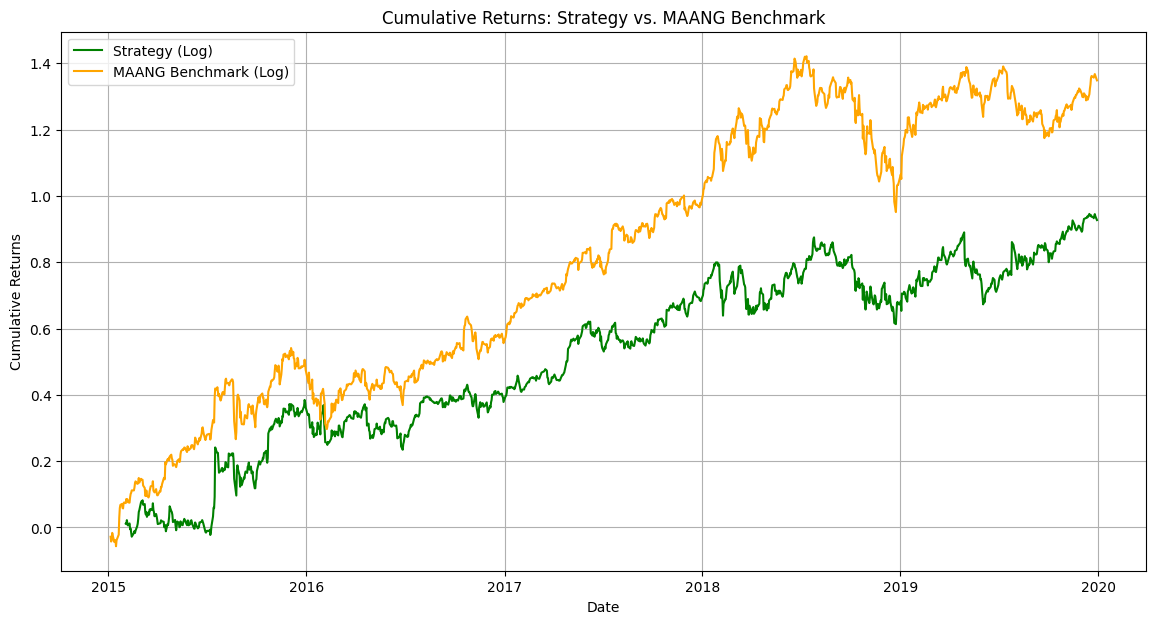

In [18]:
portfolio['Cumulative_Strategy_Returns'] = (1 + portfolio['Strategy_Returns']).cumprod()
portfolio['Cumulative_Benchmark_Returns'] = (1 + portfolio['Benchmark_Returns']).cumprod()

# Now, visualize the strategy against the benchmark
plt.figure(figsize=(14, 7))
plt.plot(portfolio.index, np.log(portfolio['Cumulative_Strategy_Returns']), label='Strategy (Log)', color='green')
plt.plot(portfolio.index, np.log(portfolio['Cumulative_Benchmark_Returns']), label='MAANG Benchmark (Log)', color='orange')
plt.title('Cumulative Returns: Strategy vs. MAANG Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()



# Visualisation of drawdowns of strategy

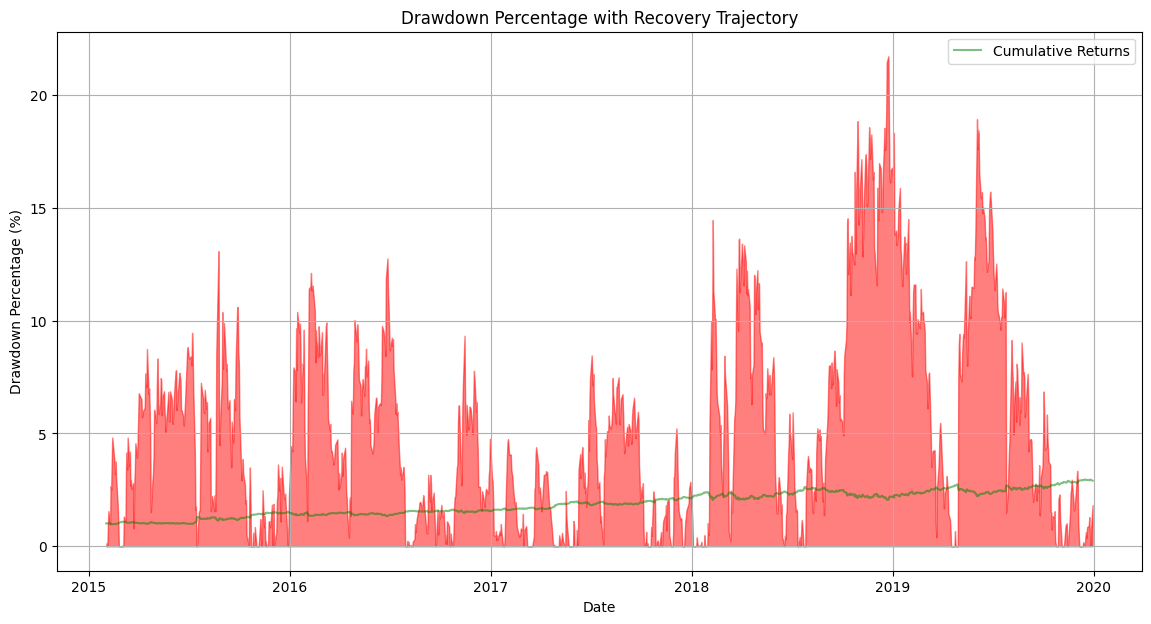

In [19]:
#Drawdown percentage
drawdown_percentage = (portfolio['Drawdown'] / portfolio["Cum_Max_Portfolio"]) * 100

# Create the drawdown visualization
plt.figure(figsize=(14, 7))
plt.fill_between(drawdown_percentage.index, drawdown_percentage, color='red', alpha=0.5)
plt.title('Drawdown Percentage with Recovery Trajectory')
plt.xlabel('Date')
plt.ylabel('Drawdown Percentage (%)')

plt.plot(portfolio["Gross_Cum_Portfolio_Returns"], label='Cumulative Returns', color='green', alpha=0.5)

plt.legend()
plt.grid()
plt.show()

# Yearly Performance of Strategy

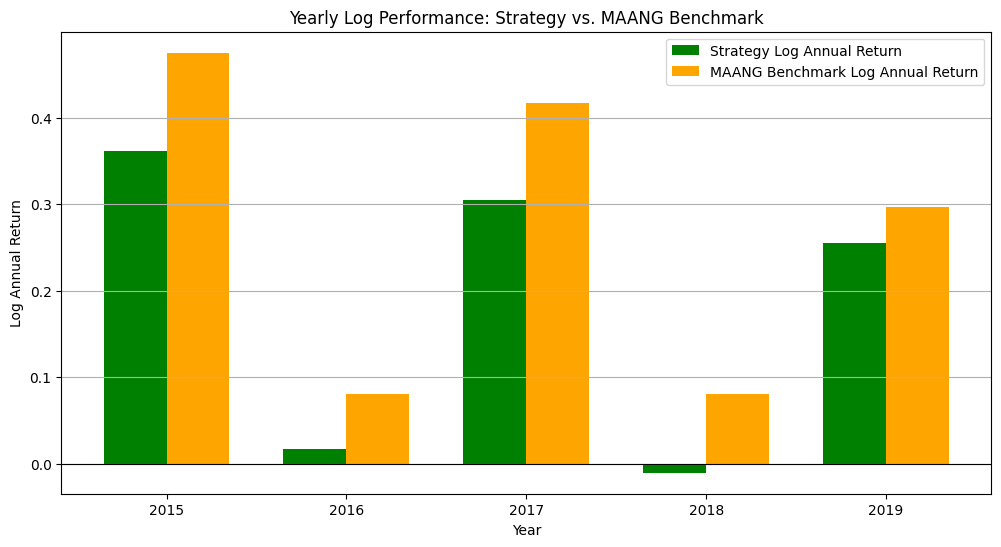

In [20]:
# Calculate Annual Log Returns
portfolio['Year'] = portfolio.index.year

# Group by Year and calculate sum of log returns for both Strategy and Benchmark
annual_log_performance = portfolio.groupby('Year').agg({
    'Log_Strategy_Returns': 'sum',  # Sum of log returns for the strategy
    'Log_Benchmark_Returns': 'sum'   # Sum of log returns for the benchmark
}).reset_index()

# Rename columns for clarity
annual_log_performance.columns = ['Year', 'Log_Strategy_Annual_Return', 'Log_Benchmark_Annual_Return']

# Plotting the Annual Log Performance
plt.figure(figsize=(12, 6))
bar_width = 0.35
x = np.arange(len(annual_log_performance['Year']))

# Plotting the Strategy Annual Log Returns
plt.bar(x - bar_width/2, annual_log_performance['Log_Strategy_Annual_Return'], 
        width=bar_width, label='Strategy Log Annual Return', color='green')

# Plotting the Benchmark Annual Log Returns
plt.bar(x + bar_width/2, annual_log_performance['Log_Benchmark_Annual_Return'], 
        width=bar_width, label='MAANG Benchmark Log Annual Return', color='orange')

# Customizing the plot
plt.xlabel('Year')
plt.ylabel('Log Annual Return')
plt.title('Yearly Log Performance: Strategy vs. MAANG Benchmark')
plt.xticks(x, annual_log_performance['Year'].astype(str))
plt.axhline(0, color='black', linewidth=0.8)  # Add a line at y=0 for better readability
plt.legend()
plt.grid(axis='y')
plt.show()



In [21]:
# Group by 'Year' and calculate the mean of the 'Gross_Cum_Portfolio_Returns' for each year
yearly_performance = portfolio.groupby('Year')['Gross_Cum_Portfolio_Returns'].last()  # Last value represents end of year

# Reset index for better formatting
yearly_performance = yearly_performance.reset_index()
yearly_performance.columns = ['Year', 'Final Returns']

yearly_performance['Mean Returns'] = portfolio.groupby('Year')['Strategy_Returns'].mean().values

# Display the yearly performance table
print(yearly_performance)


   Year  Final Returns  Mean Returns
0  2015       1.492425      0.001726
1  2016       1.548503      0.000146
2  2017       2.124793      0.001260
3  2018       2.187499      0.000116
4  2019       2.905356      0.001131
